---

In [1]:
%cd ../../../../

/home/k.rooijers/Projects/OOPS_2023


/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


---

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt

In [3]:
plt.rcParams['figure.constrained_layout.use'] = True

In [4]:
import numpy as np
import pandas as pd

In [5]:
import xarray

In [6]:
import seaborn

In [7]:
import duckdb

import blitzgsea

In [8]:
np.random.seed(42)

In [9]:
def sluggify(s):
    from string import ascii_letters, digits
    return "".join(c for c in s if c in ascii_letters or c in digits or c in "-_."
    ).replace(":", "_").replace("-", "_").replace(".", "_")

In [10]:
from pathlib import Path

---

### Data loading

In [11]:
from glob import glob

In [12]:
# geneset_result_files = glob("./data_and_coef_dashboard.ipynb")

In [13]:
sample_subset = pd.read_csv("pipeline_activation/samplesheet.tsv", sep="\t")

In [14]:
intensities = pd.read_csv(
    "pipeline_activation/intensity-values.tsv",
    sep="\t", index_col=0,
)

In [15]:
w_valid = intensities['w_valid']

In [16]:
hgnc_metadata = pd.read_csv(
    "pipeline_activation/raw/hgnc_metadata.tsv.gz",
    sep="\t", index_col=0,
)

In [17]:
DBFN = "data/vendor/KR20231013.human_omni_gene.db"

In [18]:
OUTDIR = Path("./pipeline_activation/")

---

In [19]:
dbconn = duckdb.connect(DBFN, read_only=True)

Load HDI medians:

---

- Selected coefs x Selected geneset collections
- Run all GSEA combinations, store results
- Plot NES in dotplot (actually nothing but a matrix)

In [20]:
map_ds = xarray.load_dataset(
    "pipeline_activation/model-output/global_map.h5"
)

In [21]:
E = xarray.concat([
    map_ds['E'],
    map_ds['Ederiv'].rename({"deriv_coef": "coef"}),
], dim='coef')

In [22]:
assert (hgnc_metadata[w_valid].index.values == E.coords['gene']).all().item()

In [23]:
dict(enumerate(E.coords['coef'].to_numpy().tolist()))

{0: 'Intercept',
 1: 'libtype[S.OOPS]',
 2: 'act[S.no]',
 3: 'cl[S.no]',
 4: 'libtype[S.OOPS]:act[S.no]',
 5: 'libtype[S.OOPS]:cl[S.no]',
 6: 'act[S.no]:cl[S.no]',
 7: 'libtype[S.OOPS]:act[S.no]:cl[S.no]',
 8: 'OOPS_abundance',
 9: 'activation',
 10: 'activation_FP',
 11: 'RBPness',
 12: 'lt_deltaRBPness',
 13: 'act_deltaRBPness',
 14: 'act_deltaCL'}

In [24]:
coefs = [
    'Intercept',
    'libtype[S.OOPS]',
    'activation',
    'RBPness',
    'act_deltaRBPness',
]

In [25]:
dbconn.execute("SELECT DISTINCT collection_name FROM msigdb_gene_set ORDER BY collection_name").df()

,collection_name
0,C1
1,C2:CGP
2,C2:CP
3,C2:CP:BIOCARTA
4,C2:CP:KEGG
5,C2:CP:PID
6,C2:CP:REACTOME
7,C2:CP:WIKIPATHWAYS
8,C3:MIR:MIRDB
9,C3:MIR:MIR_LEGACY


In [26]:
collections = [
    'C2:CP:KEGG',
    'C5:GO:BP',
    'C5:GO:MF',
    'C5:GO:CC',
]

Cutoff:

/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


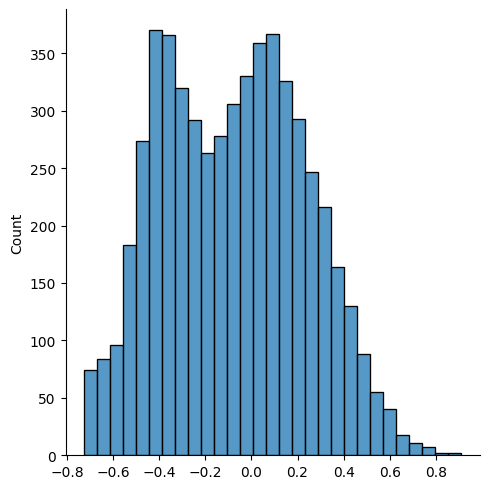

In [27]:
seaborn.displot(E.sel(coef='Intercept'))

In [28]:
low_cutoff = np.quantile(E.sel(coef='Intercept'), 0.2)

In [29]:
w_expr = (E.sel(coef='Intercept') >= low_cutoff).to_numpy()

In [30]:
symbols = hgnc_metadata[w_valid]['symbols'].values

In [31]:
blitzgsea_kwargs = dict(
    seed=42,
    permutations=10_000,
#     kl_bins=120, anchors=14,
    signature_cache=False,
    symmetric=False, center=False,
    processes=4, progress=True, verbose=True,
)

In [32]:
results = {}

for collection in collections:
    gs_library = {
        k: list(set(v))
        for (k, v) in dbconn.execute("""
    SELECT gs.standard_name, s.symbol
    FROM msigdb_gene_set as gs
    INNER JOIN msigdb_gene_set_gene_symbol as gsgs ON gsgs.gene_set_id = gs.id
    INNER JOIN msigdb_gene_symbol as s ON gsgs.gene_symbol_id = s.id
    WHERE gs.collection_name = $collection
    """, {"collection": collection}).df().groupby("standard_name")['symbol']
        if len(v) >= 5
    }
    

    for coef in coefs:
        signature_df = pd.DataFrame(
            {
                0: symbols,
                1: E.sel(coef=coef).values
            },
        )[w_expr].reset_index(drop=True)

        try:
            result = blitzgsea.gsea(
                signature_df,
                gs_library,
                **blitzgsea_kwargs,
            )
        except:
            print("Error during: %s" % str((collection, coef)))
            result = blitzgsea.gsea(
                signature_df,
                gs_library,
                **(blitzgsea_kwargs | {"ks_disable": True}),
            )
            continue
        
        results[(collection, coef)] = xarray.Dataset(result)

Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:01<00:00, 165.45it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.013759090453423082
KS p-value (neg): 0.015578297258515618


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 318.73it/s]


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.08821261316957661
KS p-value (neg): 4.242836362255063e-06


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 456.03it/s]


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.009013527927105712
KS p-value (neg): 0.010151572689067124


Enrichment : 100%|██████████████████████████████████| 186/186 [00:00<00:00, 647.93it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.005775705298881154
KS p-value (neg): 0.013000180172801216


Enrichment : 100%|█████████████████████████████████| 186/186 [00:00<00:00, 2176.35it/s]


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.01197793454213524
KS p-value (neg): 0.01304788897047465


Enrichment : 100%|███████████████████████████████| 7751/7751 [00:01<00:00, 5017.51it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.026978626751260552
KS p-value (neg): 0.22394575021765462


Enrichment : 100%|███████████████████████████████| 7751/7751 [00:01<00:00, 4706.50it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.04852271387544422
KS p-value (neg): 0.01590797269943746


Enrichment : 100%|███████████████████████████████| 7751/7751 [00:01<00:00, 4596.47it/s]


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.002846026392406198
KS p-value (neg): 0.008391962349716477


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7751/7751 [00:01<00:00, 5723.75it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.01591985418204497
KS p-value (neg): 0.09747771369301954


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7751/7751 [00:01<00:00, 6204.04it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.002981398740051823
KS p-value (neg): 0.0027021605365360065


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 5820.49it/s]

Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.038903710956371934
KS p-value (neg): 0.13919176988990092



/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))
Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 7372.46it/s]


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.042081087612975514
KS p-value (neg): 0.00946634643696876


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 8192.46it/s]

Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.003286808138950293
KS p-value (neg): 0.005700513662426886



Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 8188.43it/s]

Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.017673328088970833
KS p-value (neg): 0.09470326414412807



/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))
Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 6984.37it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.002026796102528779
KS p-value (neg): 0.0021355127190661695


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 5270.45it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.026797670086515096
KS p-value (neg): 0.1759172667853685


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 5260.06it/s]


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.06353459275799236
KS p-value (neg): 0.018803613820360963


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 4351.34it/s]

Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.004602415428993234
KS p-value (neg): 0.013422650531732595



Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 5580.14it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.015871742100050514
KS p-value (neg): 0.07999134761350465


Enrichment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 5454.57it/s]
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.00428426526279932
KS p-value (neg): 0.003274971313044618


In [33]:
list(results.keys())

[('C2:CP:KEGG', 'Intercept'),
 ('C2:CP:KEGG', 'libtype[S.OOPS]'),
 ('C2:CP:KEGG', 'activation'),
 ('C2:CP:KEGG', 'RBPness'),
 ('C2:CP:KEGG', 'act_deltaRBPness'),
 ('C5:GO:BP', 'Intercept'),
 ('C5:GO:BP', 'libtype[S.OOPS]'),
 ('C5:GO:BP', 'activation'),
 ('C5:GO:BP', 'RBPness'),
 ('C5:GO:BP', 'act_deltaRBPness'),
 ('C5:GO:MF', 'Intercept'),
 ('C5:GO:MF', 'libtype[S.OOPS]'),
 ('C5:GO:MF', 'activation'),
 ('C5:GO:MF', 'RBPness'),
 ('C5:GO:MF', 'act_deltaRBPness'),
 ('C5:GO:CC', 'Intercept'),
 ('C5:GO:CC', 'libtype[S.OOPS]'),
 ('C5:GO:CC', 'activation'),
 ('C5:GO:CC', 'RBPness'),
 ('C5:GO:CC', 'act_deltaRBPness')]

Collect the set of relevant genesets, concatenate across NES columns and genesets:

In [34]:
ds = []
for collection in collections:
    # First, identify the set of sets to collect
    sets = set()
    for coef in coefs:
        # Ignore Intercept at this stage
        if coef in ('Intercept', 'libtype[S.OOPS]'):
            continue
            
        if (collection, coef) not in results:
            print("Missing:", (collection, coef))
            continue
        subset = (
            results[(collection, coef)]
            .to_pandas()
            .assign(**{"abs_nes": lambda df: np.abs(df['nes'])})
            .sort_values("abs_nes", ascending=False)
            .loc[lambda df: df['pval'] < 1e-3]
        )
        print(len(subset), (collection, coef))
        sets.update(set(subset.index))
    
    # Collect the sets, for each coef
    d = {}
    for coef in coefs:
        if (collection, coef) not in results:
            print("Missing:", (collection, coef))
            continue
        subset = (
            results[(collection, coef)]
            .to_pandas()
            .loc[sorted(sets)]
        )
        d[coef] = subset['nes']
    d = pd.DataFrame({
        ("nes_%s" % coef): s
        for coef, s in d.items()
    })
    ds.append(d)

0 ('C2:CP:KEGG', 'activation')
0 ('C2:CP:KEGG', 'RBPness')
1 ('C2:CP:KEGG', 'act_deltaRBPness')
14 ('C5:GO:BP', 'activation')
35 ('C5:GO:BP', 'RBPness')
6 ('C5:GO:BP', 'act_deltaRBPness')
8 ('C5:GO:MF', 'activation')
21 ('C5:GO:MF', 'RBPness')
0 ('C5:GO:MF', 'act_deltaRBPness')
12 ('C5:GO:CC', 'activation')
9 ('C5:GO:CC', 'RBPness')
1 ('C5:GO:CC', 'act_deltaRBPness')


In [35]:
D = pd.concat(ds, axis=0)

D

,nes_Intercept,nes_libtype[S.OOPS],nes_activation,nes_RBPness,nes_act_deltaRBPness
Term,,,,,
KEGG_HUNTINGTONS_DISEASE,-1.001240,-3.767282,0.911034,-2.483465,-4.031909
GOBP_AMIDE_BIOSYNTHETIC_PROCESS,7.306521,-1.651153,1.453103,5.207336,-0.000000
GOBP_AMIDE_METABOLIC_PROCESS,6.672346,-1.847308,0.591436,4.589777,-0.000000
GOBP_AUTOPHAGOSOME_ORGANIZATION,-2.352485,-0.333839,-4.196699,-0.859319,-0.380213
GOBP_CELLULAR_COMPONENT_DISASSEMBLY,-0.000000,-1.510591,-3.574450,-0.000000,0.049222
...,...,...,...,...,...
GOCC_RIBOSOMAL_SUBUNIT,5.743561,-1.297589,4.034858,3.327090,0.467276
GOCC_RIBOSOME,6.047127,-1.614900,3.847382,3.417847,0.468243
GOCC_VACUOLAR_LUMEN,3.303706,-0.662472,-4.338727,-2.703522,-0.293376


In [36]:
D[~np.isfinite(D.values).all(axis=1)]

,nes_Intercept,nes_libtype[S.OOPS],nes_activation,nes_RBPness,nes_act_deltaRBPness
Term,,,,,
GOMF_ATP_DEPENDENT_ACTIVITY_ACTING_ON_RNA,3.234779,inf,0.408309,3.517518,-0.030251
GOMF_HELICASE_ACTIVITY,4.114647,inf,1.206617,3.714154,2.074349
GOMF_MRNA_3_UTR_BINDING,4.720997,inf,-0.879185,4.072432,-0.805998


In [37]:
D[:] = np.minimum(12., D.values)

In [38]:
geneset_sizes = {}

for k in results:
    s = results[k].to_pandas()['geneset_size'].to_dict()
    if any(key in geneset_sizes for key in s):
        assert all(
            geneset_sizes[key] == s[key]
            for key in s
        )
    for key in s:
        geneset_sizes[key] = s[key]

Do some clustering on the sets:

In [39]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import average, dendrogram

In [40]:
set_order = dendrogram(average(pdist(D.values, metric='cosine')), no_plot=True)['leaves']

In [41]:
from string import capwords

In [42]:
def format_geneset_name(s):
    parts = s.split("_")
#     return "%s: %s" % (parts[0], capwords(" ".join(parts[1:])))
    return "%s: %s" % (parts[0], (" ".join([p.lower() for p in parts[1:]])))

/tmp/ipykernel_272392/3953924582.py:24: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(OUTDIR / "figures/geneset_matrix_full.pdf")
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


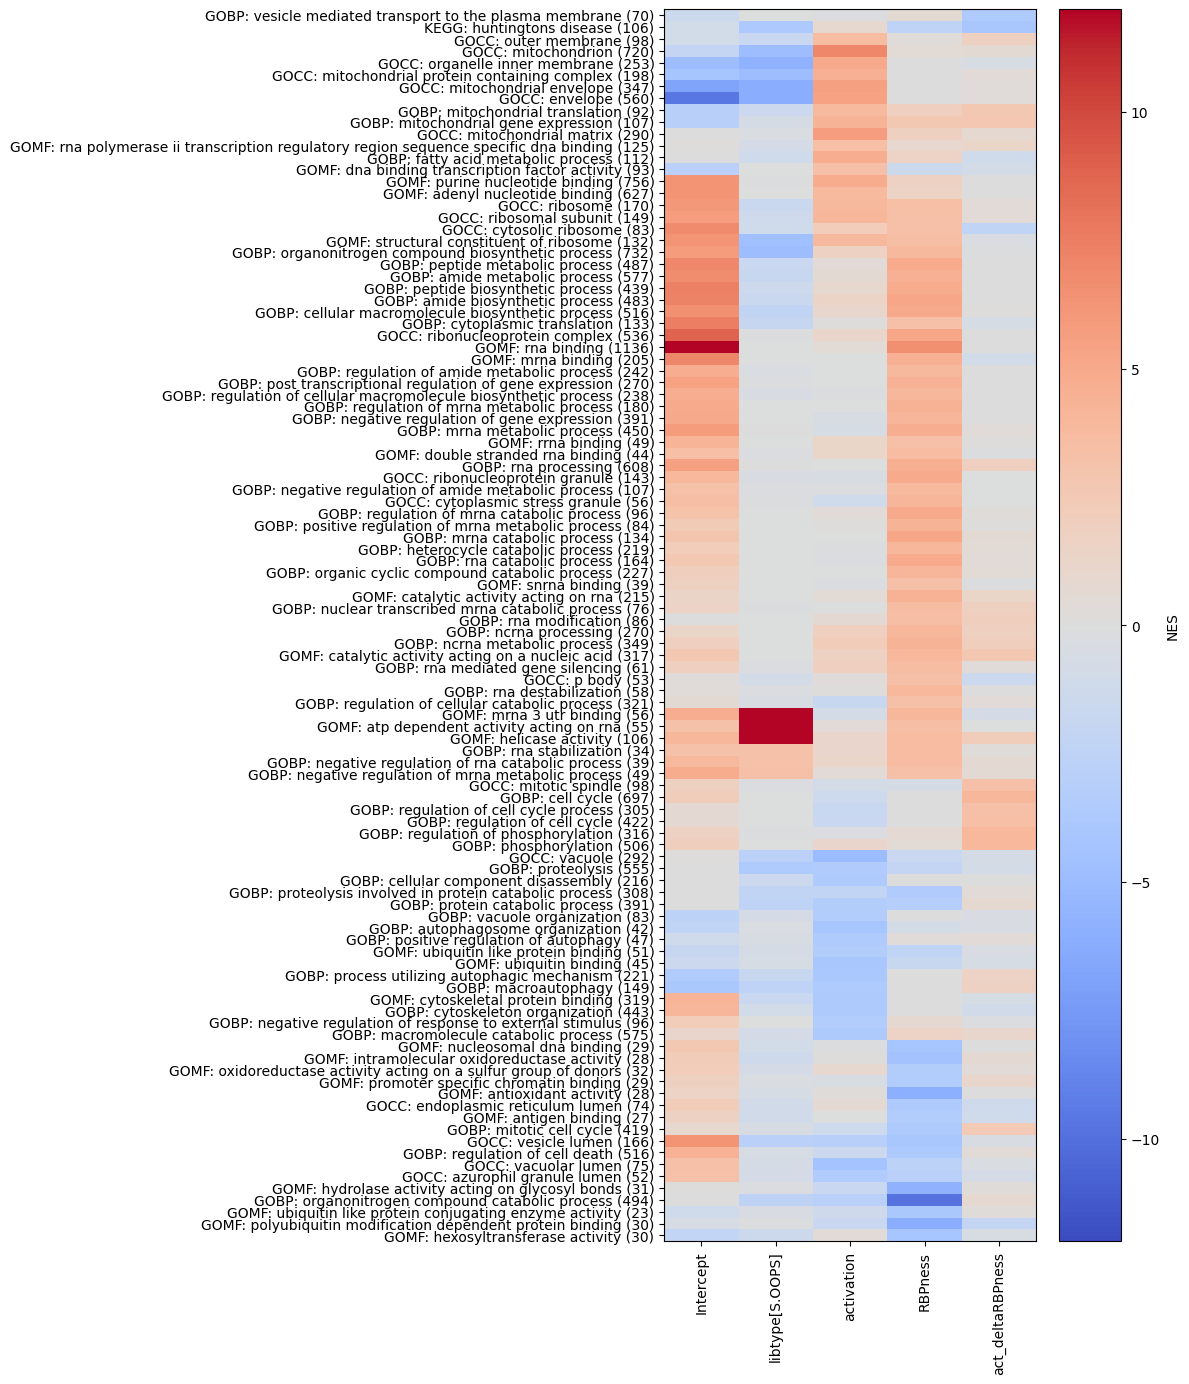

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 16))

pcm = ax.pcolormesh(
    D.iloc[set_order].values,
    vmin=-12, vmax=12.,
    cmap="coolwarm",
)

cb = fig.colorbar(
    pcm,
    ax=ax,
)
cb.set_label("NES")

ax.set_yticks(np.arange(len(D)) + 0.5)
ax.set_yticklabels([
    "%s (%d)" % (format_geneset_name(s), geneset_sizes[s])
    for s in D.iloc[set_order].index.tolist()
]);

ax.set_xticks(np.arange(D.shape[1]) + 0.5)
ax.set_xticklabels([col.replace("nes_", "") for col in D.columns], rotation=90);

fig.savefig(OUTDIR / "figures/geneset_matrix_full.pdf")

Subset genesets:

In [44]:
subset_genesets = set()

for k in results:
    if k[1] in {"Intercept", "libtype[S.OOPS]"}:
#         subset_genesets |= set(
#             results[k].to_pandas().assign(**{"abs_nes": lambda df: np.abs(df['nes'])}).loc[
#                 lambda df: (df['fdr'] <= 1e-6) & (df['abs_nes'] >= 6.)
#             ].index
#         )
        pass
    else:
        subset_genesets |= set(
            results[k].to_pandas().assign(**{"abs_nes": lambda df: np.abs(df['nes'])}).loc[
                lambda df: (df['pval'] <= 1e-6) & (df['abs_nes'] >= 3.4)
            ].index
        )

subset_genesets |= {
    "GOBP_VESICLE_MEDIATED_TRANSPORT_TO_THE_PLASMA_MEMBRANE",
}

len(subset_genesets)

20

In [45]:
D_subset = D.loc[sorted(subset_genesets)]

subset_set_order = dendrogram(average(pdist(D_subset.values, metric='cosine')), no_plot=True)['leaves']

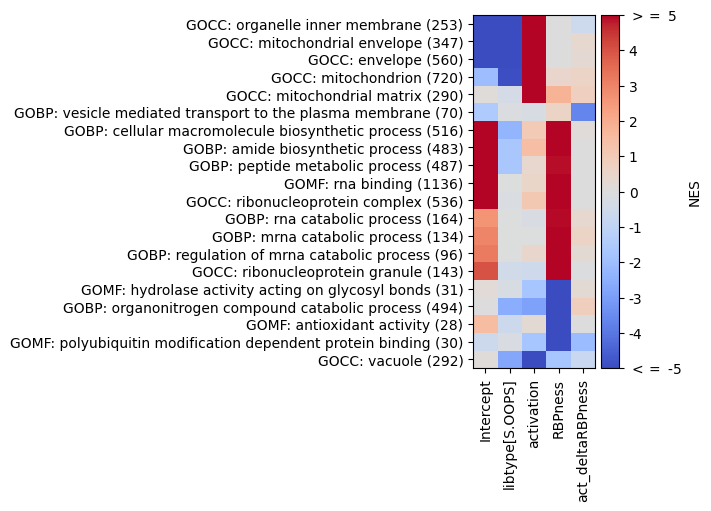

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pcm = ax.pcolormesh(
    D_subset.iloc[subset_set_order].values,
    vmin=-5, vmax=5.,
    cmap="coolwarm",
)

cb = fig.colorbar(
    pcm,
    ax=ax,
)
cb.set_label("NES")
# Indicate colorscale capping:
cb.locator = plt.matplotlib.ticker.FixedLocator(np.arange(-5, 5 + 1))
cb.set_ticklabels(
    ["$<=$ %s" % cb.get_ticks()[0]] + [
        "%s" % t for t in cb.get_ticks()[1:-1]
    ] + ["$>=$ %s" % cb.get_ticks()[-1]]
);

ax.set_yticks(np.arange(len(D_subset)) + 0.5)
ax.set_yticklabels([
    "%s (%d)" % (format_geneset_name(s), geneset_sizes[s])
    for s in D_subset.iloc[subset_set_order].index.tolist()
]);

ax.set_xticks(np.arange(D_subset.shape[1]) + 0.5)
ax.set_xticklabels([col.replace("nes_", "") for col in D_subset.columns], rotation=90);

fig.savefig(OUTDIR / "figures/geneset_matrix_subset.pdf")

If you care about dotted aesthetics:

In [47]:
from tqdm.auto import tqdm

0it [00:00, ?it/s]

/tmp/ipykernel_272392/413166309.py:25: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(OUTDIR / "figures/geneset_matrix_dotplot.pdf")
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


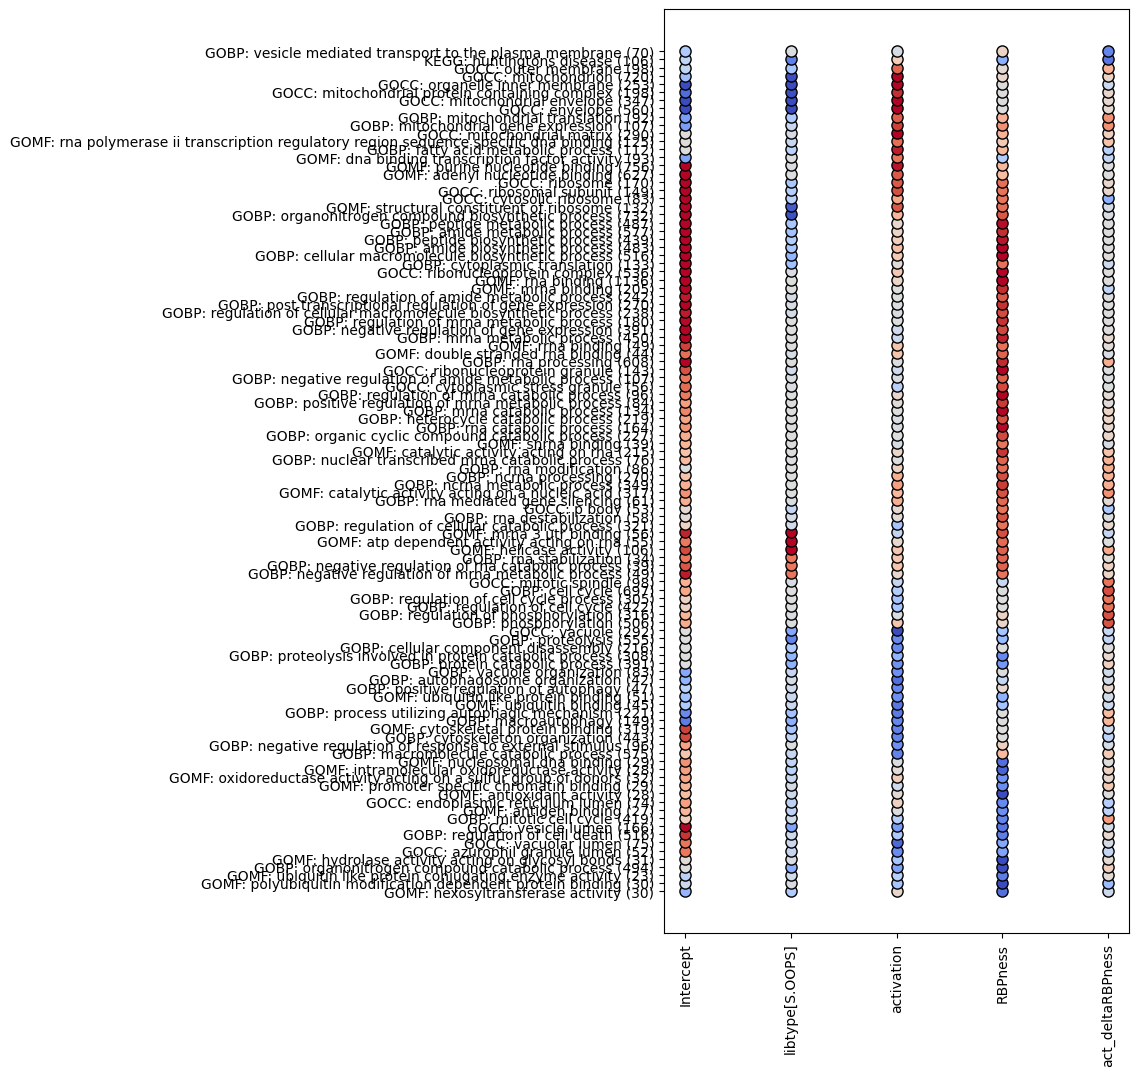

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

# cmap = plt.matplotlib.cm.get_cmap("coolwarm")
cmap = plt.matplotlib.colormaps['coolwarm']

for irow, row in tqdm(enumerate(D.iloc[set_order].values)):
    for icol, value in enumerate(row):
#         print(irow, icol, value)
        scaled_value = np.clip((value - -5) / (5 - -5), 0, 1)
        color = cmap(scaled_value)
        ax.scatter(
            icol, irow,
            s=(0.9 * 72),
            color=color,
            edgecolor='black', lw=1.,
        )
ax.set_yticks(np.arange(len(D)))
ax.set_yticklabels([
    "%s (%d)" % (format_geneset_name(s), geneset_sizes[s])
    for s in D.iloc[set_order].index.tolist()
]);
ax.set_xticks(np.arange(D.shape[1]))
ax.set_xticklabels([col.replace("nes_", "") for col in D.columns], rotation=90);

fig.savefig(OUTDIR / "figures/geneset_matrix_dotplot.pdf")

---